# Synthetic Feasibility

Synthetic feasibility is a problem when running large scale enumerations.  Ofen molecules that are enumerated are very difficult to make and thus not worth inspection even if their other chemical properties are good in silico.  This tutorial goes through how to train the [ScScore](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622) model.



The idea of the model is you train on pairs of molecules where one molecule is "more complex" than the other.  The nueral network then can make scores which attempt to keep this pairwise ordering of molecules.  The final result is a model which can give a relative complexity of a molecule.

The paper trains on every reaction in reaxys, declaring products more complex than reactions.  Since this training set is prohibitively expensive we will instead train on arbitrary molecules declaring one more complex if it's SMILES string is longer.  In the real world you can use whatever measure of complexity makes sense for the project.

In [1]:
# Lets get some molecules to play with

from deepchem.molnet.load_function import tox21_datasets
tasks, datasets, transformers = tox21_datasets.load_tox21(featurizer='Raw', split=None, reload=False)
molecules = datasets[0].X

/home/leswing/miniconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/leswing/Documents/deepchem/deepchem/models/tensorgraph/models/graph_models.py:1159: FutureWarning: GraphConvTensorGraph is deprecated and has been renamed to GraphConvModel and will be removed in DeepChem 3.0.
  FutureWarning)
/home/leswing/Documents/deepchem/deepchem/models/tensorgraph/models/graph_models.py:1170: FutureWarning: WeaveTensorGraph is deprecated and has been renamed to WeaveModel and will be removed in DeepChem 3.0.
  FutureWarning)


Loading raw samples now.
shard_size: 8192
About to start loading CSV from /tmp/tox21.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
TIMING: featurizing shard 0 took 2.963 s
TIMING: dataset construction took 3.435 s
Loading dataset from disk.
TIMING: dataset construction took 0.616 s
Loading dataset from disk.


# Make The Datasets

Because ScScore is trained on relative complexities we have our X tensor in our dataset has 3 dimensions (sample_id, molecule_id, features).  the 1st dimension molecule_id is in \[0, 1\], because a sample is a pair of molecules.  The label is 1 if the zeroth molecule is more complex than the first molecule


In the real world you could use purchase cost, or number of reaction steps required as your complexity score.

In [2]:
from rdkit import Chem
import random
from deepchem.feat import CircularFingerprint
import deepchem as dc
import numpy as np


def create_dataset(fingerprints, smiles_lens, ds_size=100000):
    """
    m1: list of np.Array
        fingerprints for molecules
    m2: list of int
        length of a molecules SMILES string
    
    returns:
        dc.data.Dataset for input into ScScore Model
        
    Dataset.X
        shape is (sample_id, molecule_id, features)
    Dataset.y
        shape is (sample_id,)
        values is 1 if the 0th index molecule is more complex
                  0 if the 1st index molecule is more complex
    """
    X, y = [], []
    all_data = list(zip(fingerprints, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
    return dc.data.NumpyDataset(np.array(X), np.expand_dims(np.array(y), axis=1))



# Lets split our dataset into a train set and a test set
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

# In the paper they used 1024 bit fingerprints with chirality
n_features=1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)
train_features = featurizer.featurize(train_mols.X)
train_smileslen = [len(Chem.MolToSmiles(x)) for x in train_mols.X]
train_dataset = create_dataset(train_features, train_smileslen)

In [3]:
from deepchem.models import ScScoreModel
# Now to create the model and train it
model = ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

8.357791900634766

# Model Performance

Lets evaluate how well the model does on our holdout molecules.  The SaScores should track the length of SMILES strings from never before seen molecules.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
mol_scores = model.predict_mols(test_mols.X)
smiles_lengths = [len(Chem.MolToSmiles(x)) for x in test_mols.X]

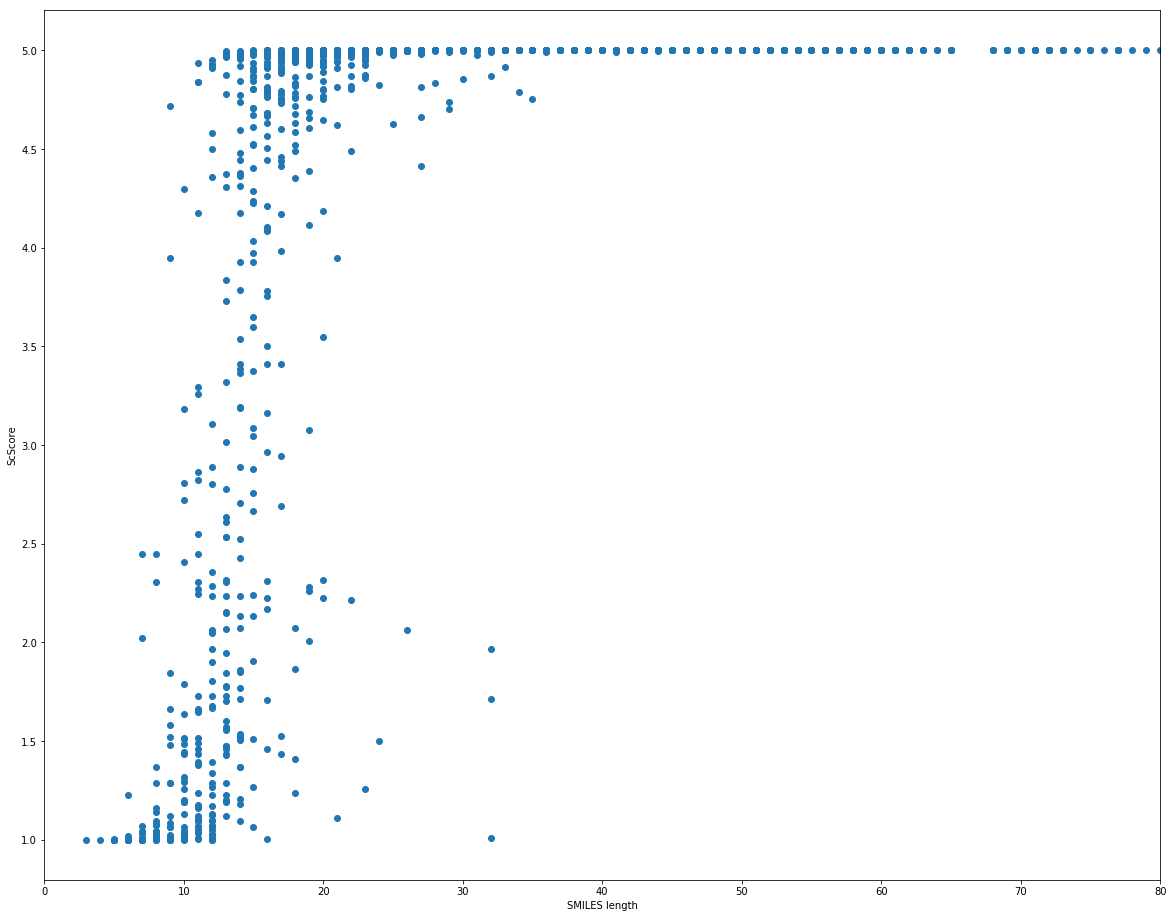

In [6]:
plt.figure(figsize=(20,16))
plt.scatter(smiles_lengths, mol_scores)
plt.xlim(0,80)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

As we can see the model generally tracks SMILES length.  It has good enrichment between 8 and 30 characters and gets both small and large SMILES strings extremes dead on.

Now you can train your own models on more meaningful metrics than SMILES length!